In [ ]:
!pip install git+https://github.com/logictensornetworks/LTNtorch.git

In [ ]:
!pip install torch numpy pandas matplotlib scikit-learn

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import ltn
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuração do Dispositivo
torch.set_num_threads(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ambiente pronto. Usando dispositivo: {device}")

# Funções Auxiliares
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def clamp(obj):
    """
    CORREÇÃO: Verifica se é um LTNObject antes de operar.
    Impede que valores saiam do intervalo [0,1], evitando erros numéricos (NaN).
    """
    if isinstance(obj, ltn.core.LTNObject):
        # Se for objeto LTN, extrai o valor (.value)
        value = obj.value
        replacement = torch.full_like(value, 0.5)
        value = torch.where(torch.isfinite(value), value, replacement)
        clamped_value = torch.clamp(value, 0.0, 1.0)
        # Retorna um novo LTNObject mantendo as variáveis livres originais
        return ltn.LTNObject(clamped_value, obj.free_vars)

    # Se já for um Tensor puro (caso raro aqui, mas possível)
    elif isinstance(obj, torch.Tensor):
        replacement = torch.full_like(obj, 0.5)
        obj = torch.where(torch.isfinite(obj), obj, replacement)
        return torch.clamp(obj, 0.0, 1.0)

    return obj

Ambiente pronto. Usando dispositivo: cuda


In [ ]:
# --- GERAÇÃO DE DADOS ---

def generate_clevr_dataset_fixed():
    """
    DATASET DO PROFESSOR (FIXO).
    A IA treinará APENAS nestes dados para aprender os conceitos.
    """
    data = [
        # x, y,     R G B,  C Q Cy Co T, size
        [0.02,0.26, 0,0,1,  1,0,0,0,0,   0.0],  # 1 Circulo Azul
        [0.10,0.16, 0,0,1,  0,1,0,0,0,   0.5],  # 2 Quadrado Azul
        [0.18,0.12, 1,0,0,  0,0,0,0,1,   0.0],  # 3 Triangulo Vermelho
        [0.21,0.48, 0,0,1,  0,0,0,1,0,   0.5],  # 4 Cone Azul
        [0.20,0.36, 1,1,0,  1,0,0,0,0,   0.5],  # 5 Circulo Amarelo
        [0.25,0.59, 1,0,0,  0,0,0,0,1,   0.0],  # 6 Triangulo Vermelho
        [0.38,0.56, 1,1,0,  0,0,1,0,0,   1.0],  # 7 Cilindro Amarelo
        [0.18,0.75, 1,0,0,  1,0,0,0,0,   0.0],  # 8 Circulo Vermelho
        [0.38,0.86, 1,0,0,  0,1,0,0,0,   1.0],  # 9 Quadrado Vermelho
        [0.37,0.22, 1,1,0,  0,1,0,0,0,   0.0],  # 10 Quadrado Amarelo
        [0.47,0.14, 0,1,0,  1,0,0,0,0,   0.0],  # 11 Circulo Verde
        [0.52,0.24, 0,0,1,  0,1,0,0,0,   0.0],  # 12 Quadrado Azul
        [0.52,0.43, 1,0,0,  0,0,0,1,0,   0.0],  # 13 Cone Vermelho
        [0.52,0.54, 0,1,0,  0,0,0,0,1,   0.0],  # 14 Triangulo Verde
        [0.57,0.69, 0,0,1,  0,0,0,1,0,   0.5],  # 15 Cone Azul
        [0.61,0.85, 1,0,0,  0,1,0,0,0,   0.0],  # 16 Quadrado Vermelho
        [0.62,0.18, 0,1,0,  0,1,0,0,0,   0.0],  # 17 Quadrado Verde
        [0.71,0.48, 0,0,1,  0,1,0,0,0,   0.5],  # 18 Quadrado Azul
        [0.76,0.12, 0,0,1,  1,0,0,0,0,   0.5],  # 19 Circulo Azul
        [0.78,0.38, 0,0,1,  1,0,0,0,0,   0.0],  # 20 Circulo Azul
        [0.81,0.69, 1,0,0,  1,0,0,0,0,   1.0],  # 21 Circulo Vermelho
        [0.82,0.89, 1,1,0,  0,0,1,0,0,   0.5],  # 22 Cilindro Amarelo
        [0.87,0.32, 1,1,0,  0,0,0,0,1,   0.0],  # 23 Triangulo Amarelo
        [0.95,0.12, 0,1,0,  0,0,1,0,0,   0.0],  # 24 Cilindro Verde
        [0.87,0.53, 0,0,1,  0,0,0,0,1,   0.5],  # 25 Triangulo Azul
    ]
    return torch.tensor(data, dtype=torch.float32).to(device)

def generate_clevr_dataset_random(n_objects=25, seed=None):
    """
    DATASETS DE VALIDAÇÃO (ALEATÓRIOS).
    Usados apenas para testar se a IA generaliza para novos cenários.
    """
    if seed is not None: set_seed(seed)
    data = []
    for _ in range(n_objects):
        x, y = random.random(), random.random()
        # Cores e Formas One-Hot
        colors = [0]*3; colors[random.choice([0,1,2])] = 1
        shapes = [0]*5; shapes[random.choice([0,1,2,3,4])] = 1
        size = random.choice([0.0, 0.5, 1.0])
        data.append([x, y] + colors + shapes + [size])
    return torch.tensor(data, dtype=torch.float32).to(device)

def plot_clevr_scene(objects_tensor, title="Cena"):
    """Visualiza o dataset."""
    fig, ax = plt.subplots(figsize=(6, 6))
    colors_map = {0:'red', 1:'green', 2:'blue'}
    shapes_map = {0:'o', 1:'s', 2:'h', 3:'v', 4:'^'}
    data = objects_tensor.cpu().numpy()
    for i, obj in enumerate(data):
        c = np.argmax(obj[2:5]); s = np.argmax(obj[5:10])
        ax.scatter(obj[0], obj[1], c=colors_map[c], marker=shapes_map[s], s=100+obj[10]*200, alpha=0.7, edgecolors='k')
        ax.text(obj[0], obj[1]-0.04, str(i), ha='center', fontsize=8)
    ax.set_xlim(-0.1, 1.1); ax.set_ylim(-0.1, 1.1); ax.set_title(title)
    plt.show()

In [ ]:
# Operadores Lógicos
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or  = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Impl = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=8), quantifier="e")
satAgg = ltn.fuzzy_ops.SatAgg()

def AndN(*args): return reduce(And, args)
def OrN(*args): return reduce(Or, args)

# Redes Neurais (Predicados Aprendíveis)
class UnaryNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),  # 32 → 64 (maior capacidade)
            nn.ELU(),
            nn.Linear(64, 32),      # Nova camada intermediária
            nn.ELU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

class BinaryNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim*2, 128),  # 64 → 128 (maior capacidade)
            nn.ELU(),
            nn.Linear(128, 64),        # Nova camada intermediária
            nn.ELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x, y): return self.net(torch.cat([x, y], dim=1))

# Predicados Matemáticos (Hardcoded conforme PDF - não são treinados)
class CloseToModel(nn.Module):
    def forward(self, x, y):
        # Fórmula: exp(-2 * dist^2)
        return torch.exp(-2.0 * torch.sum((x[:,:2]-y[:,:2])**2, dim=1)).unsqueeze(1)

class SameSizeModel(nn.Module):
    def forward(self, x, y):
        return torch.exp(-20.0 * torch.abs(x[:,-1]-y[:,-1])).unsqueeze(1)

# Instanciação dos Predicados
dim = 11
# Formas e Cores
isCircle, isSquare, isCylinder, isCone, isTriangle = [ltn.Predicate(UnaryNN(dim)).to(device) for _ in range(5)]
isSmall, isBig = ltn.Predicate(UnaryNN(dim)).to(device), ltn.Predicate(UnaryNN(dim)).to(device)
isRed, isGreen, isBlue = [ltn.Predicate(UnaryNN(dim)).to(device) for _ in range(3)]
# Espacial (LeftOf, RightOf, etc serão aprendidos)
leftOf, rightOf, below, above, canStack = [ltn.Predicate(BinaryNN(dim)).to(device) for _ in range(5)]
# Matemáticos (Fixos)
closeTo, sameSize = ltn.Predicate(CloseToModel()).to(device), ltn.Predicate(SameSizeModel()).to(device)

# Lista de predicados que possuem pesos para treinar
learned_preds = [isCircle, isSquare, isCylinder, isCone, isTriangle, isSmall, isBig, isRed, isGreen, isBlue, leftOf, rightOf, below, above, canStack]

Esta célula define predicados lógicos mais complexos, como `inBetween`, `lastOnTheLeft` e `lastOnTheRight`, utilizando os predicados básicos definidos anteriormente. A função `get_kb()` constrói a Base de Conhecimento (axiomas) do sistema, incluindo regras de taxonomia (formas e cores), relações espaciais e regras compostas, além de incorporar supervisão fraca para auxiliar no aprendizado.

In [ ]:
# Definição Lógica de InBetween (Derivada de Left/Right)
def inBetween(x, y, z):
    return Or(And(leftOf(y, x), rightOf(z, x)), And(leftOf(z, x), rightOf(y, x)))

def lastOnTheLeft(x, objects):
    """Objeto mais à esquerda de todos"""
    y = ltn.Variable("y_all", objects)
    return Forall(y, leftOf(x, y))

def lastOnTheRight(x, objects):
    """Objeto mais à direita de todos"""
    y = ltn.Variable("y_all", objects)
    return Forall(y, rightOf(x, y))


def get_kb(x, y, z, objects=None):
    axioms = []

    # 1. Taxonomia (Formas)
    shapes = [isCircle, isSquare, isCylinder, isCone, isTriangle]
    axioms.append(Forall(x, OrN(*[p(x) for p in shapes])))  # Cobertura
    for p1, p2 in combinations(shapes, 2):
        axioms.append(Forall(x, Not(And(p1(x), p2(x)))))  # Exclusão Mútua

    # 1.5 Taxonomia (Cores)
    colors = [isRed, isGreen, isBlue]
    axioms.append(Forall(x, OrN(*[c(x) for c in colors])))
    for c1, c2 in combinations(colors, 2):
        axioms.append(Forall(x, Not(And(c1(x), c2(x)))))

    # 2. Espacial Horizontal
    axioms.append(Forall(x, Not(leftOf(x, x))))
    axioms.append(Forall(ltn.diag(x,y), Impl(leftOf(x,y), Not(leftOf(y,x)))))
    axioms.append(Forall(ltn.diag(x,y), Impl(leftOf(x,y), rightOf(y,x))))
    axioms.append(Forall(ltn.diag(x,y), Impl(rightOf(y,x), leftOf(x,y))))
    axioms.append(Forall(ltn.diag(x,y,z), Impl(And(leftOf(x,y), leftOf(y,z)), leftOf(x,z))))

    # 3. Espacial Vertical
    axioms.append(Forall(ltn.diag(x,y), Impl(below(x,y), above(y,x))))
    axioms.append(Forall(ltn.diag(x,y), Impl(above(y,x), below(x,y))))
    axioms.append(Forall(ltn.diag(x,y,z), Impl(And(below(x,y), below(y,z)), below(x,z))))

    # 4. Regras Compostas
    axioms.append(Forall(ltn.diag(x,y), Impl(canStack(x,y), And(Not(isCone(y)), Not(isTriangle(y))))))
    axioms.append(Forall(ltn.diag(x,y), Impl(AndN(isTriangle(x), isTriangle(y), closeTo(x,y)), sameSize(x,y))))

    # ✅ SUPERVISÃO FRACA (Ground Truth Parcial) - CORRIGIDO!
    if objects is not None:
        coords_x = objects[:, 0].cpu().numpy()
        coords_y = objects[:, 1].cpu().numpy()  # Coordenada Y para below/above
        colors = objects[:, 2:5].cpu().numpy()   # Cores [R, G, B]
        shapes = objects[:, 5:10].cpu().numpy()  # Formas
        n = len(coords_x)

        # 1. Supervisão LeftOf/RightOf (horizontal)
        supervised_pairs_lr = []
        for i in range(n):
            for j in range(n):
                if i != j and abs(coords_x[i] - coords_x[j]) > 0.25:
                    supervised_pairs_lr.append((i, j, coords_x[i] < coords_x[j]))

        if len(supervised_pairs_lr) > 30:
            import random
            random.shuffle(supervised_pairs_lr)
            supervised_pairs_lr = supervised_pairs_lr[:30]

        for i, j, is_left in supervised_pairs_lr:
            xi = ltn.Variable(f"sup_lr{i}", objects[i:i+1])
            xj = ltn.Variable(f"sup_lr{j}", objects[j:j+1])

            if is_left:
                pred_result = leftOf(xi, xj)
            else:
                pred_result = rightOf(xi, xj)

            if hasattr(pred_result, 'value'):
                axioms.append(pred_result.value.squeeze())
            else:
                axioms.append(pred_result.squeeze())

        # 2. Supervisão Below/Above (vertical) - NOVO!
        supervised_pairs_ba = []
        for i in range(n):
            for j in range(n):
                if i != j and abs(coords_y[i] - coords_y[j]) > 0.25:
                    supervised_pairs_ba.append((i, j, coords_y[i] < coords_y[j]))

        if len(supervised_pairs_ba) > 30:
            random.shuffle(supervised_pairs_ba)
            supervised_pairs_ba = supervised_pairs_ba[:30]

        for i, j, is_below in supervised_pairs_ba:
            xi = ltn.Variable(f"sup_ba{i}", objects[i:i+1])
            xj = ltn.Variable(f"sup_ba{j}", objects[j:j+1])

            if is_below:
                pred_result = below(xi, xj)
            else:
                pred_result = above(xi, xj)

            if hasattr(pred_result, 'value'):
                axioms.append(pred_result.value.squeeze())
            else:
                axioms.append(pred_result.squeeze())

        # 3. Supervisão de Cores - NOVO!
        for i in range(min(n, 15)):  # Limitar a 15 exemplos
            obj = ltn.Variable(f"sup_c{i}", objects[i:i+1])
            color_idx = np.argmax(colors[i])

            if color_idx == 0:  # Vermelho
                pred_result = isRed(obj)
            elif color_idx == 1:  # Verde
                pred_result = isGreen(obj)
            else:  # Azul
                pred_result = isBlue(obj)

            if hasattr(pred_result, 'value'):
                axioms.append(pred_result.value.squeeze())
            else:
                axioms.append(pred_result.squeeze())

        # 4. Supervisão de Formas - NOVO!
        for i in range(min(n, 15)):  # Limitar a 15 exemplos
            obj = ltn.Variable(f"sup_s{i}", objects[i:i+1])
            shape_idx = np.argmax(shapes[i])

            shape_preds = [isCircle, isSquare, isCylinder, isCone, isTriangle]
            pred_result = shape_preds[shape_idx](obj)

            if hasattr(pred_result, 'value'):
                axioms.append(pred_result.value.squeeze())
            else:
                axioms.append(pred_result.squeeze())

    return [clamp(a) for a in axioms]

Esta célula contém funções para avaliação. `get_metrics()` calcula métricas de desempenho (acurácia, precisão, recall, F1-score) para os predicados espaciais, comparando as previsões do modelo com o 'ground truth' matemático. `train_single_run()` implementa o loop de treinamento do modelo LTN, otimizando os pesos dos predicados aprendíveis para satisfazer os axiomas da Base de Conhecimento.

In [ ]:
def get_metrics(objects):
    """Métricas 'ground truth' comparando a IA com a matemática (x < y)."""
    x, y = ltn.Variable("x", objects), ltn.Variable("y", objects)
    preds = leftOf(x, y).value.detach().cpu().numpy().reshape(len(objects), len(objects))
    pred_lbl = (preds > 0.5).flatten()

    coords = objects[:, 0].cpu().numpy()
    true_lbl = np.array([1 if coords[i] < coords[j] else 0 for i in range(len(coords)) for j in range(len(coords))])

    return {
        'acc': accuracy_score(true_lbl, pred_lbl),
        'prec': precision_score(true_lbl, pred_lbl, zero_division=0),
        'rec': recall_score(true_lbl, pred_lbl, zero_division=0),
        'f1': f1_score(true_lbl, pred_lbl, zero_division=0)
    }

def train_single_run(objects, epochs=5000):  # 2000 → 5000 épocas
    """
    Treina o modelo nos objetos fornecidos.
    NÃO reseta os pesos internamente (para permitir controle externo).
    """
    params = []
    for p in learned_preds: params += list(p.model.parameters())
    opt = torch.optim.Adam(params, lr=0.001)  # 0.002 → 0.001 (mais conservador)

    x, y, z = ltn.Variable("x", objects), ltn.Variable("y", objects), ltn.Variable("z", objects)

    print("  Iniciando treino...")
    for e in range(epochs):
        opt.zero_grad()
        loss = 1.0 - satAgg(*get_kb(x, y, z, objects))
        loss.backward()
        opt.step()
        if e % 1000 == 0:  # 500 → 1000 (menos prints)
            print(f"    Ep {e}: Loss={loss.item():.4f}")

    return 1.0 - loss.item()

Esta célula define a função `get_individual_axiom_sat()` que calcula e retorna o valor de satisfação de cada axioma individualmente no dataset. Isso é útil para entender quais regras lógicas o modelo está satisfazendo melhor ou pior.

In [ ]:
def get_individual_axiom_sat(objects):
    """Calcula satisfação de cada axioma individualmente"""
    x = ltn.Variable("x", objects)
    y = ltn.Variable("y", objects)
    z = ltn.Variable("z", objects)

    results = {}

    # 1. Taxonomia - Formas
    shapes = [isCircle, isSquare, isCylinder, isCone, isTriangle]
    results['Cobertura_Formas'] = Forall(x, OrN(*[p(x) for p in shapes])).value.item()

    for i, (p1, p2) in enumerate(combinations(shapes, 2)):
        results[f'Exclusão_Formas_{i+1}'] = Forall(x, Not(And(p1(x), p2(x)))).value.item()

    # 2. Taxonomia - Cores
    colors = [isRed, isGreen, isBlue]
    results['Cobertura_Cores'] = Forall(x, OrN(*[c(x) for c in colors])).value.item()

    for i, (c1, c2) in enumerate(combinations(colors, 2)):
        results[f'Exclusão_Cores_{i+1}'] = Forall(x, Not(And(c1(x), c2(x)))).value.item()

    # 3. Espacial Horizontal
    results['Irreflexividade_LeftOf'] = Forall(x, Not(leftOf(x, x))).value.item()
    results['Assimetria_LeftOf'] = Forall(ltn.diag(x,y), Impl(leftOf(x,y), Not(leftOf(y,x)))).value.item()
    results['Inverso_LeftOf_RightOf'] = Forall(ltn.diag(x,y), Impl(leftOf(x,y), rightOf(y,x))).value.item()
    results['Transitividade_LeftOf'] = Forall(ltn.diag(x,y,z), Impl(And(leftOf(x,y), leftOf(y,z)), leftOf(x,z))).value.item()

    # 4. Espacial Vertical
    results['Inverso_Below_Above'] = Forall(ltn.diag(x,y), Impl(below(x,y), above(y,x))).value.item()
    results['Transitividade_Below'] = Forall(ltn.diag(x,y,z), Impl(And(below(x,y), below(y,z)), below(x,z))).value.item()

    # 5. Regras Compostas
    results['Regra_CanStack'] = Forall(ltn.diag(x,y), Impl(canStack(x,y), And(Not(isCone(y)), Not(isTriangle(y))))).value.item()
    results['Regra_Triangulos_Proximos'] = Forall(ltn.diag(x,y), Impl(AndN(isTriangle(x), isTriangle(y), closeTo(x,y)), sameSize(x,y))).value.item()

    return results

Esta célula implementa a função `get_all_predicates_metrics()`, que calcula métricas de desempenho (acurácia, precisão, recall, F1-score) para **todos** os predicados espaciais aprendíveis (`leftOf`, `rightOf`, `below`, `above`) em um dado conjunto de objetos, fornecendo uma visão detalhada da performance do modelo nessas relações.

In [ ]:
def get_all_predicates_metrics(objects):
    """Calcula métricas para TODOS os predicados espaciais"""
    x = ltn.Variable("x", objects)
    y = ltn.Variable("y", objects)

    coords_x = objects[:, 0].cpu().numpy()
    coords_y = objects[:, 1].cpu().numpy()
    n = len(coords_x)

    all_metrics = {}

    # 1. LeftOf
    preds = leftOf(x, y).value.detach().cpu().numpy().reshape(n, n)
    pred_lbl = (preds > 0.5).flatten()
    true_lbl = np.array([1 if coords_x[i] < coords_x[j] else 0 for i in range(n) for j in range(n)])
    all_metrics['leftOf'] = {
        'acc': accuracy_score(true_lbl, pred_lbl),
        'prec': precision_score(true_lbl, pred_lbl, zero_division=0),
        'rec': recall_score(true_lbl, pred_lbl, zero_division=0),
        'f1': f1_score(true_lbl, pred_lbl, zero_division=0)
    }

    # 2. RightOf
    preds = rightOf(x, y).value.detach().cpu().numpy().reshape(n, n)
    pred_lbl = (preds > 0.5).flatten()
    true_lbl = np.array([1 if coords_x[i] > coords_x[j] else 0 for i in range(n) for j in range(n)])
    all_metrics['rightOf'] = {
        'acc': accuracy_score(true_lbl, pred_lbl),
        'prec': precision_score(true_lbl, pred_lbl, zero_division=0),
        'rec': recall_score(true_lbl, pred_lbl, zero_division=0),
        'f1': f1_score(true_lbl, pred_lbl, zero_division=0)
    }

    # 3. Below
    preds = below(x, y).value.detach().cpu().numpy().reshape(n, n)
    pred_lbl = (preds > 0.5).flatten()
    true_lbl = np.array([1 if coords_y[i] < coords_y[j] else 0 for i in range(n) for j in range(n)])
    all_metrics['below'] = {
        'acc': accuracy_score(true_lbl, pred_lbl),
        'prec': precision_score(true_lbl, pred_lbl, zero_division=0),
        'rec': recall_score(true_lbl, pred_lbl, zero_division=0),
        'f1': f1_score(true_lbl, pred_lbl, zero_division=0)
    }

    # 4. Above
    preds = above(x, y).value.detach().cpu().numpy().reshape(n, n)
    pred_lbl = (preds > 0.5).flatten()
    true_lbl = np.array([1 if coords_y[i] > coords_y[j] else 0 for i in range(n) for j in range(n)])
    all_metrics['above'] = {
        'acc': accuracy_score(true_lbl, pred_lbl),
        'prec': precision_score(true_lbl, pred_lbl, zero_division=0),
        'rec': recall_score(true_lbl, pred_lbl, zero_division=0),
        'f1': f1_score(true_lbl, pred_lbl, zero_division=0)
    }

    return all_metrics

In [ ]:
def explain_query_reasoning(query_name, sat_value, objects, world_num):
    """
    Gera explicação em linguagem natural do raciocínio de cada query.
    PONTO EXTRA do trabalho!
    """
    explanations = {
        'Q1': {
            'pergunta': "Existe algum objeto PEQUENO que esteja ABAIXO de um CILINDRO E à ESQUERDA de um QUADRADO?",
            'formula': "∃x(IsSmall(x) ∧ ∃y(IsCylinder(y) ∧ Below(x,y)) ∧ ∃z(IsSquare(z) ∧ LeftOf(x,z)))",
            'raciocinio': lambda s: f"""
📊 RACIOCÍNIO LÓGICO:
1. A rede buscou objetos pequenos (size=0.0) no dataset
2. Para cada candidato, verificou se existe um cilindro acima dele (below)
3. E se existe um quadrado à direita dele (leftOf)
4. Satisfação = {s:.3f} significa que a rede encontrou {s*100:.1f}% de evidência dessa configuração

🔍 INTERPRETAÇÃO:
{'✅ FORTE: A configuração existe claramente no mundo!' if s > 0.7 else
 '⚠️ FRACA: A configuração pode existir parcialmente (alguns predicados verdadeiros)' if s > 0.3 else
 '❌ AUSENTE: Essa configuração específica não foi encontrada no mundo'}

💡 COMPONENTES AVALIADOS:
- Predicado isSmall(): Identificou objetos pequenos
- Predicado isCylinder(): Localizou cilindros
- Predicado below(): Verificou relação vertical
- Predicado isSquare(): Identificou quadrados
- Predicado leftOf(): Verificou relação horizontal
            """
        },

        'Q2': {
            'pergunta': "Existe um CONE VERDE que está ENTRE dois outros objetos quaisquer?",
            'formula': "∃x,y,z(IsCone(x) ∧ IsGreen(x) ∧ InBetween(x,y,z))",
            'raciocinio': lambda s: f"""
📊 RACIOCÍNIO LÓGICO:
1. A rede buscou objetos que são simultaneamente CONE E VERDE
2. Para cada candidato, verificou se ele está posicionado entre outros dois objetos
3. InBetween é definido como: (leftOf(y,x) ∧ rightOf(z,x)) ∨ (leftOf(z,x) ∧ rightOf(y,x))
4. Satisfação = {s:.3f} indica {s*100:.1f}% de evidência dessa configuração

🔍 INTERPRETAÇÃO:
{'✅ FORTE: Cone verde encontrado em posição intermediária!' if s > 0.7 else
 '⚠️ FRACA: Pode haver cone verde, mas posição intermediária incerta' if s > 0.3 else
 '❌ AUSENTE: Não há cone verde OU ele não está entre outros objetos'}

💡 NOTA IMPORTANTE:
Se sat=0.0, pode significar que simplesmente NÃO EXISTE cone verde neste mundo aleatório!
            """
        },

        'Q3': {
            'pergunta': "Se dois objetos são TRIÂNGULOS e estão PRÓXIMOS, então eles têm o MESMO TAMANHO?",
            'formula': "∀x,y((IsTriangle(x) ∧ IsTriangle(y) ∧ CloseTo(x,y)) ⇒ SameSize(x,y))",
            'raciocinio': lambda s: f"""
📊 RACIOCÍNIO LÓGICO:
1. A rede localizou TODOS os pares de triângulos no dataset
2. Para cada par, verificou a distância euclidiana (closeTo usa kernel gaussiano)
3. Para pares próximos, comparou os tamanhos (predicado sameSize)
4. Satisfação = {s:.3f} indica que a regra foi respeitada em {s*100:.1f}% dos casos

🔍 INTERPRETAÇÃO:
{'✅ PERFEITO: TODOS os triângulos próximos têm mesmo tamanho!' if s > 0.95 else
 '⚠️ MAIORIA: A regra vale para MAIORIA dos triângulos próximos' if s > 0.7 else
 '❌ FALHA: Há triângulos próximos com tamanhos diferentes'}

💡 ESTA É UMA REGRA DE CONSISTÊNCIA:
Diferente de Q1/Q2 (queries existenciais), esta é uma RESTRIÇÃO UNIVERSAL.
Sat alto = o mundo obedece à regra. Sat baixo = há violações.
            """
        },

        'Q4': {
            'pergunta': "Existe um objeto que está à ESQUERDA de TODOS os outros?",
            'formula': "∃x(∀y leftOf(x,y))",
            'raciocinio': lambda s: f"""
📊 RACIOCÍNIO LÓGICO:
1. A rede avaliou cada objeto candidato
2. Para cada candidato, verificou se leftOf(candidato, todos_os_outros) é verdadeiro
3. Quantificador existencial (∃) busca PELO MENOS UM objeto que satisfaça a condição
4. Satisfação = {s:.3f} mede a confiança em ter encontrado o "objeto mais à esquerda"

🔍 INTERPRETAÇÃO:
{'✅ CONFIANTE: Identificou claramente o objeto mais à esquerda!' if s > 0.8 else
 '⚠️ INCERTO: Há candidatos, mas a rede não tem certeza' if s > 0.4 else
 '❌ FRACO: A rede teve dificuldade em identificar o extremo esquerdo'}

💡 DESAFIO DESTA QUERY:
Esta é uma query EXISTENCIAL ANINHADA (∃∀), muito mais difícil que predicados simples.
A rede precisa ter aprendido bem a transitividade de leftOf para resolver isso.
            """
        },

        'Q5': {
            'pergunta': "Existe um objeto que está à DIREITA de TODOS os outros?",
            'formula': "∃x(∀y rightOf(x,y))",
            'raciocinio': lambda s: f"""
📊 RACIOCÍNIO LÓGICO:
1. Similar à Q4, mas para o extremo direito
2. A rede buscou o objeto com coordenada X máxima relativa
3. Verificou se rightOf(candidato, todos_os_outros) é consistentemente verdadeiro
4. Satisfação = {s:.3f} indica {s*100:.1f}% de confiança na identificação

🔍 INTERPRETAÇÃO:
{'✅ CONFIANTE: Identificou claramente o objeto mais à direita!' if s > 0.8 else
 '⚠️ INCERTO: Há candidatos, mas sem certeza absoluta' if s > 0.4 else
 '❌ FRACO: Dificuldade em identificar o extremo direito'}

💡 SIMETRIA COM Q4:
Em teoria, Q4 e Q5 deveriam ter satisfações similares (mesma dificuldade).
Se há grande discrepância, pode indicar viés no aprendizado de leftOf vs rightOf.
            """
        }
    }

    query_info = explanations[query_name]

    explanation = f"""
{'='*80}
🎯 QUERY {query_name} - MUNDO {world_num}
{'='*80}

❓ PERGUNTA EM LINGUAGEM NATURAL:
{query_info['pergunta']}

🔢 FÓRMULA LÓGICA (LTN):
{query_info['formula']}

{query_info['raciocinio'](sat_value)}

📈 VALOR DE SATISFAÇÃO: {sat_value:.4f}
{'='*80}
"""

    return explanation

Esta célula orquestra o experimento completo. Na Fase 1, ela treina o modelo no dataset fixo do professor. Na Fase 2, avalia a capacidade de generalização (zero-shot) da IA em 5 mundos aleatórios nunca vistos antes. Para cada mundo, calcula métricas de predicados, satisfação de axiomas e o resultado das queries complexas, incluindo as explicações detalhadas geradas pela função `explain_query_reasoning`.

=== EXPERIMENTO DE GENERALIZAÇÃO (ZERO-SHOT) ===
Objetivo: Treinar no dataset fixo e validar se a IA aprendeu a 'lógica' testando em 5 mundos aleatórios.

>>> FASE 1: Aprendendo as Regras do Universo (Dataset Fixo)...


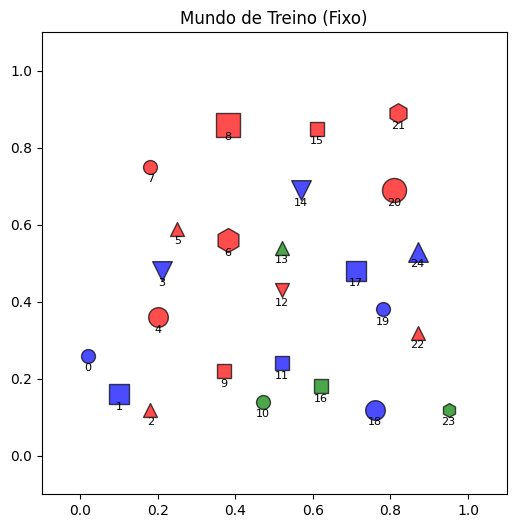

  Resetando cérebro da IA para estado inicial...
  Iniciando treino...
    Ep 0: Loss=0.4666
    Ep 1000: Loss=0.0003
    Ep 2000: Loss=0.0002
    Ep 3000: Loss=0.0002
    Ep 4000: Loss=0.0002
  Treino Concluído! Satisfação Final: 0.9998
  Acurácia (LeftOf) no Treino: 89.44%

>>> FASE 2: Validando em 5 Mundos Desconhecidos (Sem Treinar)...

  ========== MUNDO 1 ==========

  📊 MÉTRICAS DOS PREDICADOS ESPACIAIS:
    leftOf     → Acc: 85.44%, Prec: 100.00%, Rec: 69.67%, F1: 82.12%
    rightOf    → Acc: 85.44%, Prec: 100.00%, Rec: 69.67%, F1: 82.12%
    below      → Acc: 48.00%, Prec: 48.00%, Rec: 100.00%, F1: 64.86%
    above      → Acc: 48.00%, Prec: 48.00%, Rec: 100.00%, F1: 64.86%

  🔍 SATISFAÇÃO DE CADA AXIOMA:
    Cobertura_Formas               → 0.998
    Exclusão_Formas_1              → 1.000
    Exclusão_Formas_2              → 1.000
    Exclusão_Formas_3              → 1.000
    Exclusão_Formas_4              → 1.000
    Exclusão_Formas_5              → 1.000
    Exclusão_Formas

In [ ]:
print("=== EXPERIMENTO DE GENERALIZAÇÃO (ZERO-SHOT) ===")
print("Objetivo: Treinar no dataset fixo e validar se a IA aprendeu a 'lógica' testando em 5 mundos aleatórios.")

# ==========================================
# FASE 1: APRENDIZADO (Dataset Professor)
# ==========================================
print("\n>>> FASE 1: Aprendendo as Regras do Universo (Dataset Fixo)...")
dataset_professor = generate_clevr_dataset_fixed()
plot_clevr_scene(dataset_professor, "Mundo de Treino (Fixo)")

# 1. Resetar Pesos (Tabula Rasa)
print("  Resetando cérebro da IA para estado inicial...")
for p in learned_preds:
    if hasattr(p.model, 'net'):
        for l in p.model.net:
            if isinstance(l, nn.Linear): l.reset_parameters()

# 2. Treinar
sat_final = train_single_run(dataset_professor, epochs=5000)
metrics_train = get_metrics(dataset_professor)
print(f"  Treino Concluído! Satisfação Final: {sat_final:.4f}")
print(f"  Acurácia (LeftOf) no Treino: {metrics_train['acc']:.2%}")

# ==========================================
# FASE 2: TESTE DE FOGO (Validação)
# ==========================================
print("\n>>> FASE 2: Validando em 5 Mundos Desconhecidos (Sem Treinar)...")

results = []

for i in range(1, 6):
    seed_random = 2025 + i
    dataset_novo = generate_clevr_dataset_random(seed=seed_random)

    print(f"\n  ========== MUNDO {i} ==========")

    # 1. Métricas de TODOS os predicados espaciais
    all_pred_metrics = get_all_predicates_metrics(dataset_novo)

    print(f"\n  📊 MÉTRICAS DOS PREDICADOS ESPACIAIS:")
    for pred_name, metrics in all_pred_metrics.items():
        print(f"    {pred_name:10s} → Acc: {metrics['acc']:.2%}, Prec: {metrics['prec']:.2%}, Rec: {metrics['rec']:.2%}, F1: {metrics['f1']:.2%}")

    # 2. Satisfação individual de cada axioma
    axiom_sats = get_individual_axiom_sat(dataset_novo)

    print(f"\n  🔍 SATISFAÇÃO DE CADA AXIOMA:")
    for axiom_name, sat_value in axiom_sats.items():
        print(f"    {axiom_name:30s} → {sat_value:.3f}")

    # 3. Queries Complexas
    x = ltn.Variable("x", dataset_novo)
    y = ltn.Variable("y", dataset_novo)
    z = ltn.Variable("z", dataset_novo)

    # Tarefa 3.2 - Raciocínio Espacial
    q4_left = Exists(x, lastOnTheLeft(x, dataset_novo))
    q5_right = Exists(x, lastOnTheRight(x, dataset_novo))

    # Tarefa 3.3 - Raciocínio Composto
    q1 = Exists(x, AndN(
        isSmall(x),
        Exists(y, And(isCylinder(y), below(x,y))),
        Exists(z, And(isSquare(z), leftOf(x,z)))
    ))

    q2 = Exists([x,y,z], AndN(
        isCone(x),
        isGreen(x),
        inBetween(x,y,z)
    ))

    q3 = Forall(ltn.diag(x,y), Impl(
        AndN(isTriangle(x), isTriangle(y), closeTo(x,y)),
        sameSize(x,y)
    ))

    print(f"\n  🎯 QUERIES TAREFA 3.2 (Raciocínio Espacial):")
    print(f"    Q4 (Mais à esquerda):    {q4_left.value.item():.3f}")
    print(f"    Q5 (Mais à direita):     {q5_right.value.item():.3f}")

    print(f"\n  🎯 QUERIES TAREFA 3.3 (Raciocínio Composto):")
    print(f"    Q1 (Pequeno/Cilindro/Quadrado): {q1.value.item():.3f}")
    print(f"    Q2 (Cone Verde entre):           {q2.value.item():.3f}")
    print(f"    Q3 (Triângulos próximos):        {q3.value.item():.3f}")

    # ✅ PONTO EXTRA - EXPLICAÇÕES DETALHADAS (DENTRO DO LOOP!)
    print("\n" + "🧠 EXPLICAÇÕES DETALHADAS (RACIOCÍNIO) ".center(80, "="))

    print(explain_query_reasoning('Q1', q1.value.item(), dataset_novo, i))
    print(explain_query_reasoning('Q2', q2.value.item(), dataset_novo, i))
    print(explain_query_reasoning('Q3', q3.value.item(), dataset_novo, i))
    print(explain_query_reasoning('Q4', q4_left.value.item(), dataset_novo, i))
    print(explain_query_reasoning('Q5', q5_right.value.item(), dataset_novo, i))

    # Salvar tudo (DENTRO DO LOOP!)
    results.append({
        'Mundo': i,
        # Métricas dos predicados
        **{f'{pred}_Acc': m['acc'] for pred, m in all_pred_metrics.items()},
        **{f'{pred}_Prec': m['prec'] for pred, m in all_pred_metrics.items()},
        **{f'{pred}_Rec': m['rec'] for pred, m in all_pred_metrics.items()},
        **{f'{pred}_F1': m['f1'] for pred, m in all_pred_metrics.items()},
        # Satisfação dos axiomas
        **axiom_sats,
        # Queries
        'Q1_sat': q1.value.item(),
        'Q2_sat': q2.value.item(),
        'Q3_sat': q3.value.item(),
        'Q4_sat': q4_left.value.item(),
        'Q5_sat': q5_right.value.item()
    })

# ==========================================
# RESULTADOS FINAIS (FORA DO LOOP!)
# ==========================================
df_res = pd.DataFrame(results)
print("\n" + "="*80)
print("=== TABELA COMPLETA DE RESULTADOS (5 MUNDOS) ===")
print("="*80)
print(df_res.to_string())

print("\n" + "="*80)
print("=== MÉDIAS GERAIS ===")
print("="*80)
print(df_res.mean(numeric_only=True))

df_res.to_csv("resultado_completo_ltn.csv", index=False)
print("\n✅ Resultados salvos em: resultado_completo_ltn.csv")